In [141]:
import pandas as pd
import numpy as np

import csv
import re
import itertools
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler, RobustScaler

In [278]:
train = pd.read_csv("../input/2021-travelers-modeling-competition/train_2021.csv", dtype={"zip_code" : object})
test = pd.read_csv("../input/2021-travelers-modeling-competition/test_2021.csv", dtype={"zip_code" : object})

# Gather Sense of Our Data:

In [85]:
pd.set_option('display.max_columns', None)
train.head(10)

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,1,46,M,1.0,85,38301,1,1,Rent,80006,12/16/2016,Friday,Local,1,0.0,74,Broker,0,7530.940993,9.0,Compact,12885.45235,white,16161.33381,0
1,3,21,F,0.0,75,30445,0,1,Rent,15021,2/12/2015,Thursday,Highway,1,1.0,79,Online,0,2966.024895,4.0,Large,29429.45218,white,28691.96422,0
2,4,49,F,0.0,87,38923,0,1,Own,20158,12/6/2016,Tuesday,Local,0,0.0,0,Broker,0,6283.888333,3.0,Compact,21701.18195,white,22090.94758,1
3,5,58,F,1.0,58,40605,1,0,Own,15024,5/5/2016,Thursday,Local,3,0.0,99,Broker,1,6169.747994,4.0,Medium,13198.27344,other,38329.58106,1
4,6,38,M,1.0,95,36380,1,0,Rent,50034,10/27/2015,Tuesday,Highway,0,1.0,7,Broker,0,4541.387150,7.0,Medium,38060.21122,gray,25876.56319,0
5,7,56,F,0.0,72,40240,0,0,Own,50047,11/16/2016,Wednesday,Highway,0,0.0,64,Phone,0,5388.645056,4.0,Medium,17688.20498,black,15234.08204,1
6,8,27,M,1.0,80,32952,1,0,Rent,15001,3/14/2015,Saturday,Parking Lot,0,0.0,50,Online,1,8960.072399,7.0,Compact,26411.53682,red,28994.53868,0
7,10,40,M,1.0,79,36891,1,1,Own,80016,1/7/2016,Thursday,Local,5,0.0,95,Online,1,13844.364900,8.0,Medium,11355.27013,other,34045.83028,0
8,12,45,F,0.0,86,38069,0,1,Own,15024,3/31/2015,Tuesday,Parking Lot,0,0.0,3,Broker,0,6038.501514,5.0,Compact,49267.97071,black,23206.50804,0
9,15,31,M,1.0,80,34324,0,1,Rent,85032,9/3/2015,Thursday,Parking Lot,0,0.0,9,Broker,0,5869.947858,5.0,Large,19929.78577,white,37277.75910,0


In [86]:
train.describe(include = 'all')

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
count,17998.000000,17998.000000,17998,17993.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998,17998.000000,17998,17998,17998,17998.000000,17866.000000,17998.000000,17998,17998.000000,17981.000000,17990.000000,17998,17998.000000,17998,17998.000000,17998.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,NaN,731,7,3,NaN,NaN,NaN,3,NaN,NaN,NaN,3,NaN,7,NaN,NaN
top,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,Own,NaN,9/14/2016,Saturday,Local,NaN,NaN,NaN,Broker,NaN,NaN,NaN,Compact,NaN,black,NaN,NaN
freq,NaN,NaN,9414,NaN,NaN,NaN,NaN,NaN,9969,NaN,39,2630,8768,NaN,NaN,NaN,9633,NaN,NaN,NaN,6063,NaN,2620,NaN,NaN
mean,14970.601622,43.695466,NaN,0.712722,73.562951,37367.655684,0.699189,0.577286,NaN,49875.595955,NaN,NaN,NaN,0.505001,0.232677,49.423269,NaN,0.600678,4975.792083,5.008060,NaN,23089.123114,NaN,23031.322385,0.156462
std,8659.940765,11.959819,NaN,0.452505,15.346807,2957.297249,0.458623,0.494004,NaN,29214.655149,NaN,NaN,NaN,0.955504,0.422550,33.678470,NaN,0.489773,2215.706510,2.258391,NaN,11988.429767,NaN,12052.385584,0.363303
min,1.000000,18.000000,NaN,0.000000,1.000000,-1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,282.639432,0.000000,NaN,2457.329316,NaN,2429.429302,0.000000
25%,7479.250000,35.000000,NaN,0.000000,65.000000,35554.000000,0.000000,0.000000,NaN,20111.000000,NaN,NaN,NaN,0.000000,0.000000,17.000000,NaN,0.000000,3337.029436,3.000000,NaN,14279.574850,NaN,14164.122133,0.000000
50%,14965.500000,43.000000,NaN,1.000000,76.000000,37610.000000,1.000000,1.000000,NaN,50028.000000,NaN,NaN,NaN,0.000000,0.000000,50.000000,NaN,1.000000,4668.796318,5.000000,NaN,20948.879250,NaN,20838.150260,0.000000
75%,22467.750000,51.000000,NaN,1.000000,85.000000,39318.000000,1.000000,1.000000,NaN,80038.000000,NaN,NaN,NaN,1.000000,0.000000,81.000000,NaN,1.000000,6255.901066,6.000000,NaN,29562.232780,NaN,29430.446293,0.000000


In [87]:
train['fraud'].value_counts().to_frame().T

,0,1
fraud,15182,2816


In [88]:
print('No Frauds', round(train['fraud'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('Frauds', round(train['fraud'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

No Frauds 84.35 % of the dataset
Frauds 15.65 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

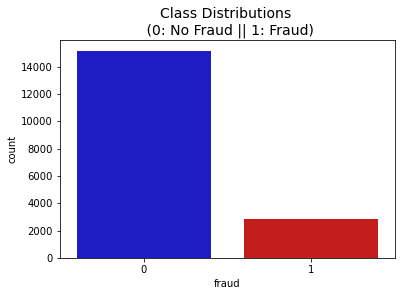

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='fraud', data=train, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

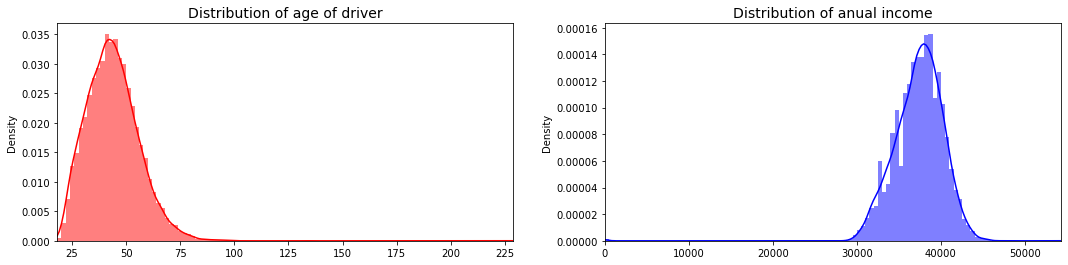

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

age_val = train['age_of_driver'].values
inc_val = train['annual_income'].values

sns.histplot(age_val, ax=ax[0], color='r', kde=True, stat="density", linewidth=0, binwidth=2)
ax[0].set_title('Distribution of age of driver', fontsize=14)
ax[0].set_xlim([min(age_val), max(age_val)])

sns.histplot(inc_val, ax=ax[1], color='b', kde=True, stat="density", linewidth=0, binwidth=500)
ax[1].set_title('Distribution of anual income', fontsize=14)
ax[1].set_xlim([min(inc_val), max(inc_val)])

plt.show()

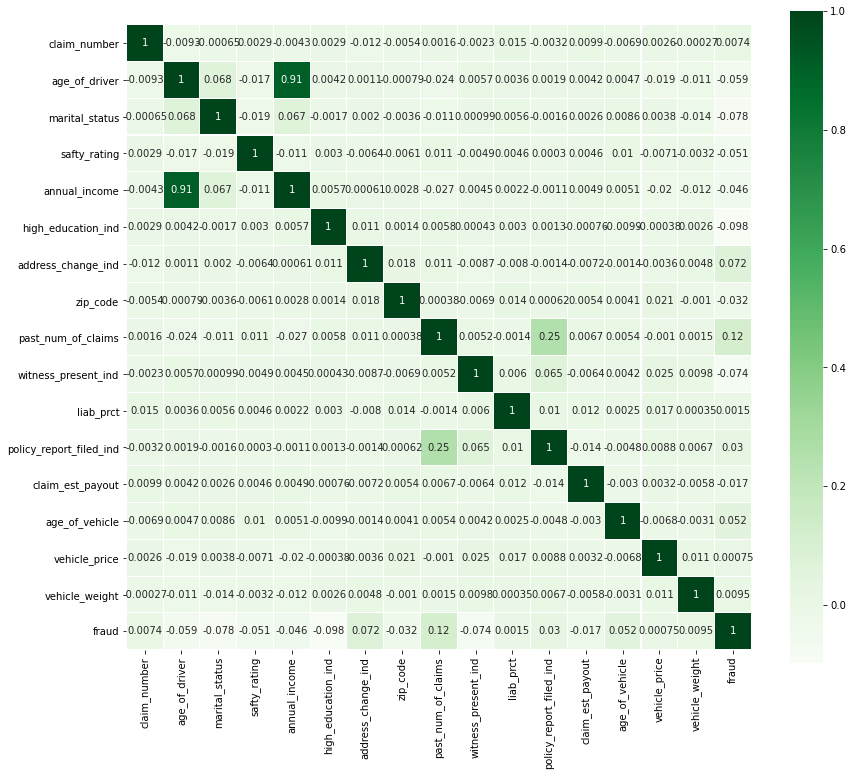

In [45]:
colormap = plt.cm.Greens

plt.figure(figsize=(14,12))

sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap = colormap, linecolor='white', annot=True)
plt.show()

In [91]:
train.shape

(17998, 25)

## Abnormal value

In [92]:
train.dtypes

claim_number                 int64
age_of_driver                int64
gender                      object
marital_status             float64
safty_rating                 int64
annual_income                int64
high_education_ind           int64
address_change_ind           int64
living_status               object
zip_code                     int64
claim_date                  object
claim_day_of_week           object
accident_site               object
past_num_of_claims           int64
witness_present_ind        float64
liab_prct                    int64
channel                     object
policy_report_filed_ind      int64
claim_est_payout           float64
age_of_vehicle             float64
vehicle_category            object
vehicle_price              float64
vehicle_color               object
vehicle_weight             float64
fraud                        int64
dtype: object

In [93]:
train['fraud'].unique()

array([0, 1])

In [96]:
train['annual_income'].min()

-1

In [95]:
train['marital_status'].unique()

array([ 1.,  0., nan])

In [101]:
np.sort(train['age_of_driver'].unique())

array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 113, 133, 200, 229])

In [279]:
## annual_income

train.loc[train.annual_income==-1, 'annual_income'] = np.nan
test.loc[test.annual_income==-1, 'annual_income'] = np.nan

In [280]:
## age_of_driver
train.loc[train.age_of_driver>100, 'age_of_driver'] = np.nan
test.loc[test.age_of_driver>100, 'age_of_driver'] = np.nan

In [281]:
# set claim_number as index:

train = train.set_index('claim_number')
test = test.set_index('claim_number')

## Encode Categorical Variables

In [282]:
train["marital_status"] = pd.Categorical(train["marital_status"])
train["high_education_ind"] = pd.Categorical(train["high_education_ind"])
train["address_change_ind"] = pd.Categorical(train["address_change_ind"])
train["zip_code"] = pd.Categorical(train["zip_code"])
train["witness_present_ind"] = pd.Categorical(train["witness_present_ind"])
train["policy_report_filed_ind"] = pd.Categorical(train["policy_report_filed_ind"])
train["fraud"] = pd.Categorical(train["fraud"])

test["marital_status"] = pd.Categorical(test["marital_status"])
test["high_education_ind"] = pd.Categorical(test["high_education_ind"])
test["address_change_ind"] = pd.Categorical(test["address_change_ind"])
test["zip_code"] = pd.Categorical(test["zip_code"])
test["witness_present_ind"] = pd.Categorical(test["witness_present_ind"])
test["policy_report_filed_ind"] = pd.Categorical(test["policy_report_filed_ind"])

In [283]:
month_dict = {
    1 : 'January',
    2 : 'February',
    3 : 'March',
    4 : 'April',
    5 : 'May',
    6 : 'June',
    7 : 'July',
    8 : 'August',
    9 : 'September',
    10 : 'October',
    11 : 'November',
    12 : 'December'
}
### On the train data
train["claim_month"] = train['claim_date'].apply(
    lambda x: month_dict[int(re.search("^(\d+)/", x).group(1))])
train["claim_day"] = train['claim_date'].apply(
    lambda x: int(re.search("/(\d+)/", x).group(1)))
train["claim_year"] = train['claim_date'].apply(
    lambda x: int(re.search("/(\d+)$", x).group(1)))


### On the test data
test["claim_month"] = test['claim_date'].apply(
    lambda x: month_dict[int(re.search("^(\d+)/", x).group(1))])
test["claim_day"] = test['claim_date'].apply(
    lambda x: int(re.search("/(\d+)/", x).group(1)))
test["claim_year"] = test['claim_date'].apply(
    lambda x: int(re.search("/(\d+)$", x).group(1)))

In [167]:
train.dtypes

age_of_driver               float64
gender                       object
marital_status             category
safty_rating                  int64
annual_income               float64
high_education_ind         category
address_change_ind         category
living_status                object
zip_code                   category
claim_date                   object
claim_day_of_week            object
accident_site                object
past_num_of_claims            int64
witness_present_ind        category
liab_prct                     int64
channel                      object
policy_report_filed_ind    category
claim_est_payout            float64
age_of_vehicle              float64
vehicle_category             object
vehicle_price               float64
vehicle_color                object
vehicle_weight              float64
fraud                      category
claim_month                  object
claim_day                     int64
claim_year                    int64
latitude                    

## Add new features: Lat/Lon/State

In [284]:
with open("../input/2021-travelers-modeling-competition/zip_code_database.csv", newline='') as csvfile:
    csv_reader = csv.DictReader(csvfile, delimiter=',')
    zip_to_lat = {}
    zip_to_lon = {}
    zip_to_state = {}
    for zip_data in csv_reader:
        zip_to_lat[zip_data['zip']] = float(zip_data['latitude'])
        zip_to_lon[zip_data['zip']] = float(zip_data['longitude'])
        zip_to_state[zip_data['zip']] = zip_data['state']
        
### assuming the '0' zip code is NaN (no such thing as a zip code of 0)   
zip_to_lat[np.nan] = np.nan
zip_to_lon[np.nan] = np.nan
zip_to_state[np.nan] = np.nan

zip_to_lat['0'] = np.nan
zip_to_lon['0'] = np.nan
zip_to_state['0'] = np.nan

### transform zip code to latitude, longitude, and state
latitude_train = train['zip_code'].apply(
    lambda x: zip_to_lat[x]
)
longitude_train = train['zip_code'].apply(
    lambda x: zip_to_lon[x]
)
state_train = train['zip_code'].apply(
    lambda x: zip_to_state[x]
)
latitude_train.name = 'latitude'
longitude_train.name = 'longitude'
state_train.name = 'state'

latitude_test = test['zip_code'].apply(
    lambda x: zip_to_lat[x]
)
longitude_test = test['zip_code'].apply(
    lambda x: zip_to_lon[x]
)
state_test = test['zip_code'].apply(
    lambda x: zip_to_state[x]
)
latitude_test.name = 'latitude'
longitude_test.name = 'longitude'
state_test.name = 'state'


### Add these new features to the data frame
train = pd.concat([train, latitude_train], axis=1)
train = pd.concat([train, longitude_train], axis=1)
train = pd.concat([train, state_train], axis=1)
train["state"] = pd.Categorical(train["state"])

test = pd.concat([test, latitude_test], axis=1)
test = pd.concat([test, longitude_test], axis=1)
test = pd.concat([test, state_test], axis=1)
test["state"] = pd.Categorical(test["state"])

In [127]:
train.describe()

,age_of_driver,safty_rating,annual_income,past_num_of_claims,liab_prct,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,claim_day,claim_year,latitude,longitude
count,17994.000000,17998.000000,17983.000000,17998.000000,17998.000000,17981.000000,17990.000000,17998.000000,17998.000000,17998.000000,17998.000000,17975.000000,17975.000000
mean,43.667667,73.562951,37398.825669,0.505001,49.423269,4975.792083,5.008060,23089.123114,23031.322385,15.734582,2015.493722,38.847519,-93.640355
std,11.793723,15.346807,2754.466463,0.955504,33.678470,2215.706510,2.258391,11988.429767,12052.385584,8.810833,0.499974,2.854546,13.517062
min,18.000000,1.000000,28896.000000,0.000000,0.000000,282.639432,0.000000,2457.329316,2429.429302,1.000000,2015.000000,33.300000,-112.280000
25%,35.000000,65.000000,35555.000000,0.000000,17.000000,3337.029436,3.000000,14279.574850,14164.122133,8.000000,2015.000000,38.790000,-105.090000
50%,43.000000,76.000000,37610.000000,0.000000,50.000000,4668.796318,5.000000,20948.879250,20838.150260,16.000000,2015.000000,39.790000,-93.600000
75%,51.000000,85.000000,39318.500000,1.000000,81.000000,6255.901066,6.000000,29562.232780,29430.446293,23.000000,2016.000000,40.630000,-79.860000
max,100.000000,100.000000,54333.000000,6.000000,100.000000,17218.345010,16.000000,127063.506000,123016.650400,31.000000,2016.000000,42.640000,-77.350000


## Missing values

In [105]:
train.isnull().sum()

age_of_driver                4
gender                       0
marital_status               5
safty_rating                 0
annual_income               15
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

In [285]:
# mean of age_of_driver
age_of_driver_mean = train.age_of_driver.mean()
train['age_of_driver'].fillna(age_of_driver_mean, inplace=True)
test['age_of_driver'].fillna(age_of_driver_mean, inplace=True)

# mode of marital_status
marital_status_mode = train.marital_status.mode().values[0]
train['marital_status'].fillna(marital_status_mode, inplace=True)
test['marital_status'].fillna(marital_status_mode, inplace=True)

# average of annual_income
annual_income_mean = train.annual_income.mean()
train['annual_income'].fillna(annual_income_mean, inplace=True)
test['annual_income'].fillna(annual_income_mean, inplace=True)

# mode of witness_present_ind
witness_present_mode = train.witness_present_ind.mode().values[0]
train['witness_present_ind'].fillna(witness_present_mode, inplace=True)
test['witness_present_ind'].fillna(witness_present_mode, inplace=True)

# mean of claim_est_payout
claim_est_payout_mean = train.claim_est_payout.mean()
train['claim_est_payout'].fillna(claim_est_payout_mean, inplace=True)
test['claim_est_payout'].fillna(claim_est_payout_mean, inplace=True)

# mean of age_of_vehicle
age_of_vehicle_mean = train.age_of_vehicle.mean()
train['age_of_vehicle'].fillna(age_of_vehicle_mean, inplace=True)
test['age_of_vehicle'].fillna(age_of_vehicle_mean, inplace=True)

# mean latitude
latitude_mean = train.latitude.mean()
train['latitude'].fillna(latitude_mean, inplace=True)
test['latitude'].fillna(latitude_mean, inplace=True)

# mean longitude
longitude_mean = train.longitude.mean()
train['longitude'].fillna(longitude_mean, inplace=True)
test['longitude'].fillna(longitude_mean, inplace=True)

# mode of state
state_mode = train.state.mode().values[0]
train['state'].fillna(state_mode, inplace=True)
test['state'].fillna(state_mode, inplace=True)

In [129]:
train.isnull().sum()

age_of_driver              0
gender                     0
marital_status             0
safty_rating               0
annual_income              0
high_education_ind         0
address_change_ind         0
living_status              0
zip_code                   0
claim_date                 0
claim_day_of_week          0
accident_site              0
past_num_of_claims         0
witness_present_ind        0
liab_prct                  0
channel                    0
policy_report_filed_ind    0
claim_est_payout           0
age_of_vehicle             0
vehicle_category           0
vehicle_price              0
vehicle_color              0
vehicle_weight             0
fraud                      0
claim_month                0
claim_day                  0
claim_year                 0
latitude                   0
longitude                  0
state                      0
dtype: int64

## One-hot-encoding

In [286]:
## Encode categorical variables that have more than two categories using one hot encoding. 

train_encoded = pd.get_dummies(train, columns=['claim_day_of_week',
                                       'accident_site',
                                       'channel',
                                       'vehicle_category',
                                       'vehicle_color',
                                       'claim_month',
                                       'state',
                                       'gender',
                                       'living_status',
                                       'marital_status',
                                       'high_education_ind',
                                       'address_change_ind',
                                       'witness_present_ind',
                                       'policy_report_filed_ind' ])

test_encoded = pd.get_dummies(test, columns=['claim_day_of_week',
                                       'accident_site',
                                       'channel',
                                       'vehicle_category',
                                       'vehicle_color',
                                       'claim_month',
                                       'state',
                                       'gender',
                                       'living_status',
                                       'marital_status',
                                       'high_education_ind',
                                       'address_change_ind',
                                       'witness_present_ind',
                                       'policy_report_filed_ind' ])
                                   
train_encoded.head()

,age_of_driver,safty_rating,annual_income,zip_code,claim_date,past_num_of_claims,liab_prct,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud,claim_day,claim_year,latitude,longitude,claim_day_of_week_Friday,claim_day_of_week_Monday,claim_day_of_week_Saturday,claim_day_of_week_Sunday,claim_day_of_week_Thursday,claim_day_of_week_Tuesday,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium,vehicle_color_black,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,claim_month_April,claim_month_August,claim_month_December,claim_month_February,claim_month_January,claim_month_July,claim_month_June,claim_month_March,claim_month_May,claim_month_November,claim_month_October,claim_month_September,state_AZ,state_CO,state_IA,state_PA,state_VA,gender_F,gender_M,living_status_Own,living_status_Rent,marital_status_0.0,marital_status_1.0,high_education_ind_0,high_education_ind_1,address_change_ind_0,address_change_ind_1,witness_present_ind_0.0,witness_present_ind_1.0,policy_report_filed_ind_0,policy_report_filed_ind_1
claim_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46.0,85,38301.0,80006,12/16/2016,1,74,7530.940993,9.0,12885.45235,16161.33381,0,16,2016,39.82,-105.10,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0
3,21.0,75,30445.0,15021,2/12/2015,1,79,2966.024895,4.0,29429.45218,28691.96422,0,12,2015,40.38,-80.39,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0
4,49.0,87,38923.0,20158,12/6/2016,0,0,6283.888333,3.0,21701.18195,22090.94758,1,6,2016,39.13,-77.66,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0
5,58.0,58,40605.0,15024,5/5/2016,3,99,6169.747994,4.0,13198.27344,38329.58106,1,5,2016,40.54,-79.80,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1
6,38.0,95,36380.0,50034,10/27/2015,0,7,4541.387150,7.0,38060.21122,25876.56319,0,27,2015,42.47,-93.64,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0


## Formating data for xgboost

In [291]:
## Drop unecessary columns

X = train_encoded.drop(['fraud', 'zip_code', 'claim_date', ], axis=1).copy()
X.head()

,age_of_driver,safty_rating,annual_income,past_num_of_claims,liab_prct,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,claim_day,claim_year,latitude,longitude,claim_day_of_week_Friday,claim_day_of_week_Monday,claim_day_of_week_Saturday,claim_day_of_week_Sunday,claim_day_of_week_Thursday,claim_day_of_week_Tuesday,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium,vehicle_color_black,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,claim_month_April,claim_month_August,claim_month_December,claim_month_February,claim_month_January,claim_month_July,claim_month_June,claim_month_March,claim_month_May,claim_month_November,claim_month_October,claim_month_September,state_AZ,state_CO,state_IA,state_PA,state_VA,gender_F,gender_M,living_status_Own,living_status_Rent,marital_status_0.0,marital_status_1.0,high_education_ind_0,high_education_ind_1,address_change_ind_0,address_change_ind_1,witness_present_ind_0.0,witness_present_ind_1.0,policy_report_filed_ind_0,policy_report_filed_ind_1
claim_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46.0,85,38301.0,1,74,7530.940993,9.0,12885.45235,16161.33381,16,2016,39.82,-105.10,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0
3,21.0,75,30445.0,1,79,2966.024895,4.0,29429.45218,28691.96422,12,2015,40.38,-80.39,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0
4,49.0,87,38923.0,0,0,6283.888333,3.0,21701.18195,22090.94758,6,2016,39.13,-77.66,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0
5,58.0,58,40605.0,3,99,6169.747994,4.0,13198.27344,38329.58106,5,2016,40.54,-79.80,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1
6,38.0,95,36380.0,0,7,4541.387150,7.0,38060.21122,25876.56319,27,2015,42.47,-93.64,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0


In [292]:
y = train_encoded['fraud'].copy()
y.head()

claim_number
1    0
3    0
4    1
5    1
6    0
Name: fraud, dtype: category
Categories (2, int64): [0, 1]

In [293]:
sum(y)/len(y)

0.15646182909212134

## Build a XGBoost model

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [260]:
X.shape

(17998, 67)

In [261]:
X_train.shape

(13498, 67)

In [190]:
## test the stratify

sum(y_train)/len(y_train)

0.15646762483330864

In [191]:
sum(y_test)/len(y_test)

0.15644444444444444

In [201]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            missing=None, seed=42, use_label_encoder=False)

clf_xgb.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr', # area under pr curve
            eval_set=[(X_test, y_test)], # evaluation how many trees to build using the test dataset
            )

[0]	validation_0-aucpr:0.25438
[1]	validation_0-aucpr:0.26838
[2]	validation_0-aucpr:0.27146
[3]	validation_0-aucpr:0.27801
[4]	validation_0-aucpr:0.28057
[5]	validation_0-aucpr:0.28393
[6]	validation_0-aucpr:0.28861
[7]	validation_0-aucpr:0.28686
[8]	validation_0-aucpr:0.29081
[9]	validation_0-aucpr:0.29278
[10]	validation_0-aucpr:0.29177
[11]	validation_0-aucpr:0.29112
[12]	validation_0-aucpr:0.29121
[13]	validation_0-aucpr:0.28917
[14]	validation_0-aucpr:0.28776
[15]	validation_0-aucpr:0.28646
[16]	validation_0-aucpr:0.28691
[17]	validation_0-aucpr:0.28521
[18]	validation_0-aucpr:0.28563
[19]	validation_0-aucpr:0.28448


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

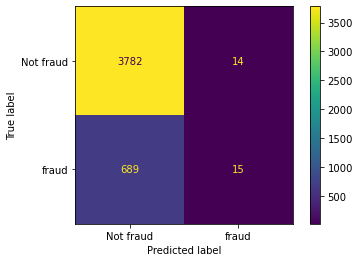

In [202]:
plot_confusion_matrix(clf_xgb, X_test, y_test, 
                      values_format='d', # 表格显示
                      display_labels=['Not fraud', 'fraud'])

## Optimize parameters using cross-validation and grid-search

In [241]:
## step1 tuning

param_grid = {
    'max_depth': [4], # default=6
    'learning_rate': [0.1,0.05,0.01], # eta, default=0.3
    'gamma': [0], # default=0
    'reg_lambda': [1.0], # default=1
    'scale_pos_weight': [4,5,6] # balance the positive and negative weights via scale_pos_weight
}

grid = GridSearchCV(clf_xgb, param_grid, scoring='f1' ,cv=10)

In [242]:
grid.fit(X_train,y_train)

[01:46:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:46:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:46:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:47:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:47:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:47:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:48:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:48:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:48:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=1, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.05, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, monotone_constraints='()',
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=0,
                                     scale_pos_weight=5, seed=42, subsample=0.9,
                                     tree_method='exact',
                                     use_label_encoder=False

In [244]:
grid.best_params_

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 1.0,
 'scale_pos_weight': 5}

In [245]:
## step2 tuning

param_grid = {
    'max_depth': [4], # default=6
    'learning_rate': [0.05], # eta, default=0.3
    'gamma': [0,0.25,1.0], # default=0
    'reg_lambda': [0,1.0,10.0], # default=1
    'scale_pos_weight': [5] # balance the positive and negative weights via scale_pos_weight
}

grid = GridSearchCV(clf_xgb, param_grid, scoring='f1' ,cv=10)

In [246]:
grid.fit(X_train,y_train)
grid.best_params_

[01:53:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:54:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:54:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:54:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:54:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:54:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:55:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 5}

In [248]:
## step3 tuning

param_grid = {
    'max_depth': [4], # default=6
    'learning_rate': [0.05], # eta, default=0.3
    'gamma': [0], # default=0
    'reg_lambda': [10.0,15,20], # default=1
    'scale_pos_weight': [5] # balance the positive and negative weights via scale_pos_weight
}

grid = GridSearchCV(clf_xgb, param_grid, scoring='f1' ,cv=10)

In [249]:
grid.fit(X_train,y_train)
grid.best_params_

[01:59:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

[01:59:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 15,
 'scale_pos_weight': 5}

## build final XGBoost model

In [343]:
X_train.shape

(13498, 67)

In [346]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            missing=None, 
                            seed=42, 
                            use_label_encoder=False,
                            gamma=0,
                            learning_rate=0.05,
                            reg_lambda=15,
                            scale_pos_weight=5,
                            max_depth=4,
                            subsample=0.9,
                            colsample_bytree=0.5)

clf_xgb.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10, # train until aucpr hasn't improve in 10 rounds
            eval_metric='aucpr', # area under pr curve
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.22241
[1]	validation_0-aucpr:0.25690
[2]	validation_0-aucpr:0.26755
[3]	validation_0-aucpr:0.26453
[4]	validation_0-aucpr:0.27635
[5]	validation_0-aucpr:0.28472
[6]	validation_0-aucpr:0.28177
[7]	validation_0-aucpr:0.28876
[8]	validation_0-aucpr:0.28878
[9]	validation_0-aucpr:0.28640
[10]	validation_0-aucpr:0.28455
[11]	validation_0-aucpr:0.28620
[12]	validation_0-aucpr:0.28891
[13]	validation_0-aucpr:0.29016
[14]	validation_0-aucpr:0.29109
[15]	validation_0-aucpr:0.29314
[16]	validation_0-aucpr:0.29140
[17]	validation_0-aucpr:0.29233
[18]	validation_0-aucpr:0.29472
[19]	validation_0-aucpr:0.29490
[20]	validation_0-aucpr:0.29685
[21]	validation_0-aucpr:0.29587
[22]	validation_0-aucpr:0.29526
[23]	validation_0-aucpr:0.29638
[24]	validation_0-aucpr:0.29734
[25]	validation_0-aucpr:0.29702
[26]	validation_0-aucpr:0.29739
[27]	validation_0-aucpr:0.29838
[28]	validation_0-aucpr:0.29930
[29]	validation_0-aucpr:0.30117
[30]	validation_0-aucpr:0.30270
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=15, scale_pos_weight=5, seed=42,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

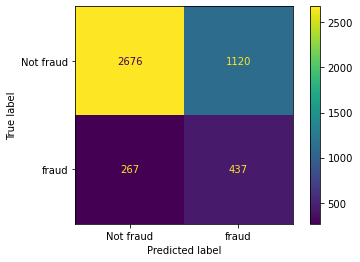

In [347]:
plot_confusion_matrix(clf_xgb, X_test, y_test, 
                      values_format='d', # 表格显示
                      display_labels=['Not fraud', 'fraud'])




In [215]:
from sklearn.metrics import f1_score

In [296]:
# Obtain the predictions from our random forest model 
y_pred = clf_xgb.predict(X_test)


f1_score(y_test, y_pred, average='binary')

0.38655462184873945

In [350]:
clf_xgb.feature_importances_

array([0.03772917, 0.01933701, 0.02912024, 0.04222961, 0.01314172,
       0.01929056, 0.01693987, 0.011126  , 0.01174743, 0.01016372,
       0.01952215, 0.01042689, 0.01419286, 0.01356853, 0.00462278,
       0.00743114, 0.00700723, 0.01053178, 0.01133597, 0.00278494,
       0.02731043, 0.03997242, 0.07209147, 0.0055797 , 0.01046995,
       0.00214853, 0.00870314, 0.01091318, 0.00954287, 0.00642467,
       0.00310584, 0.00809573, 0.00945933, 0.00797415, 0.00703946,
       0.00618522, 0.00708352, 0.01116983, 0.00792314, 0.01298978,
       0.        , 0.00294547, 0.00534269, 0.00460232, 0.00824162,
       0.0061275 , 0.00772804, 0.00580253, 0.        , 0.00900155,
       0.        , 0.        , 0.01694915, 0.0226458 , 0.02129481,
       0.0094633 , 0.01181911, 0.02923178, 0.03253408, 0.03933277,
       0.04695849, 0.02240209, 0.02636795, 0.02575648, 0.03786044,
       0.01004946, 0.01111059], dtype=float32)

## predict the test data

In [258]:
test.shape

(12002, 29)

In [287]:
test.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,claim_month,claim_day,claim_year,latitude,longitude,state
claim_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,39.0,M,1.0,73,36633.0,1,0,Own,50048,8/12/2016,Friday,Highway,0,0.0,25,Phone,0,5196.552552,8.0,Large,24360.59273,silver,26633.27819,August,12,2016,41.50,-94.52,IA
9,56.0,M,1.0,63,40252.0,1,1,Own,85068,1/2/2015,Friday,Highway,0,1.0,50,Broker,1,7381.165248,6.0,Large,39710.42665,other,15875.34874,January,2,2015,33.67,-112.06,AZ
11,39.0,F,0.0,75,36634.0,1,1,Own,20115,1/12/2016,Tuesday,Parking Lot,0,0.0,98,Broker,1,5612.123938,7.0,Medium,50327.56618,silver,21365.05932,January,12,2016,38.87,-77.85,VA
13,33.0,M,1.0,72,34960.0,0,1,Own,50006,10/18/2015,Sunday,Local,0,1.0,45,Phone,0,7957.267641,2.0,Medium,23457.35282,black,26707.46021,October,18,2015,42.51,-93.37,IA
14,24.0,F,1.0,70,31776.0,1,1,Rent,20122,9/4/2016,Sunday,Local,0,1.0,11,Online,0,6232.195932,1.0,Medium,18238.39202,silver,22949.73744,September,4,2016,38.84,-77.44,VA


In [288]:
test_encoded.drop(['zip_code', 'claim_date'], axis=1, inplace=True)

In [289]:
test_encoded.head()

,age_of_driver,safty_rating,annual_income,past_num_of_claims,liab_prct,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,claim_day,claim_year,latitude,longitude,claim_day_of_week_Friday,claim_day_of_week_Monday,claim_day_of_week_Saturday,claim_day_of_week_Sunday,claim_day_of_week_Thursday,claim_day_of_week_Tuesday,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,channel_Broker,channel_Online,channel_Phone,vehicle_category_Compact,vehicle_category_Large,vehicle_category_Medium,vehicle_color_black,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,claim_month_April,claim_month_August,claim_month_December,claim_month_February,claim_month_January,claim_month_July,claim_month_June,claim_month_March,claim_month_May,claim_month_November,claim_month_October,claim_month_September,state_AZ,state_CO,state_IA,state_PA,state_VA,gender_F,gender_M,living_status_Own,living_status_Rent,marital_status_0.0,marital_status_1.0,high_education_ind_0,high_education_ind_1,address_change_ind_0,address_change_ind_1,witness_present_ind_0.0,witness_present_ind_1.0,policy_report_filed_ind_0,policy_report_filed_ind_1
claim_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,39.0,73,36633.0,0,25,5196.552552,8.0,24360.59273,26633.27819,12,2016,41.50,-94.52,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0
9,56.0,63,40252.0,0,50,7381.165248,6.0,39710.42665,15875.34874,2,2015,33.67,-112.06,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
11,39.0,75,36634.0,0,98,5612.123938,7.0,50327.56618,21365.05932,12,2016,38.87,-77.85,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1
13,33.0,72,34960.0,0,45,7957.267641,2.0,23457.35282,26707.46021,18,2015,42.51,-93.37,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0
14,24.0,70,31776.0,0,11,6232.195932,1.0,18238.39202,22949.73744,4,2016,38.84,-77.44,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0


In [297]:
y_model = clf_xgb.predict(test_encoded)

In [300]:
y_model.shape

(12002,)

In [335]:
submission = pd.read_csv("../input/2021-travelers-modeling-competition/test_2021.csv")

In [336]:
submission.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight
0,2,39,M,1.0,73,36633,1,0,Own,50048,8/12/2016,Friday,Highway,0,0.0,25,Phone,0,5196.552552,8.0,Large,24360.59273,silver,26633.27819
1,9,56,M,1.0,63,40252,1,1,Own,85068,1/2/2015,Friday,Highway,0,1.0,50,Broker,1,7381.165248,6.0,Large,39710.42665,other,15875.34874
2,11,39,F,0.0,75,36634,1,1,Own,20115,1/12/2016,Tuesday,Parking Lot,0,0.0,98,Broker,1,5612.123938,7.0,Medium,50327.56618,silver,21365.05932
3,13,33,M,1.0,72,34960,0,1,Own,50006,10/18/2015,Sunday,Local,0,1.0,45,Phone,0,7957.267641,2.0,Medium,23457.35282,black,26707.46021
4,14,24,F,1.0,70,31776,1,1,Rent,20122,9/4/2016,Sunday,Local,0,1.0,11,Online,0,6232.195932,1.0,Medium,18238.39202,silver,22949.73744


In [337]:
submission['pred'] = y_model

In [338]:
submission = submission[['claim_number', 'pred']]

In [339]:
submission.head()

,claim_number,pred
0,2,0
1,9,0
2,11,0
3,13,0
4,14,0


In [328]:
submission.shape

(12002, 2)

In [340]:
submission.to_csv('subm.csv', index=False)

In [331]:
pwd

'/Users/minzefang/team-lm/kaggle/working'

In [332]:
sub_samp = pd.read_csv("../input/2021-travelers-modeling-competition/submission_sample.csv")

In [333]:
sub_samp.head()

,claim_number,fraud
0,2,0
1,9,0
2,11,0
3,13,0
4,14,0
